# Long COVID Likelihood Prediction using Synthea Data
## Advanced LLM Reasoning Methods with Risk Stratification
### Leveraging LLM Reasoning Methods (Zero-Shot, Few-Shot, Chain-of-Thought, Tree-of-Thought)


## Importing necessary libraries

In [1]:
import pandas as pd
import openai
from openai import OpenAI
import numpy as np
import os
import tiktoken
import time
from tqdm import tqdm
from dotenv import load_dotenv


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, average_precision_score 
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

In [2]:
load_dotenv()
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

## Healthcare Issue Description
**Problem**: Predict Long COVID likelihood from acute-phase medical data  
**Objective**: Develop LLM framework to assess risk as:
- High Likelihood
- Moderate Likelihood 
- Low Likelihood
- Unlikely

**Key Factors**:
1. Acute-phase symptom severity
2. Comorbid conditions
3. Medication regimens
4. Hospitalization/procedures
5. Lab abnormalities

In [3]:
def load_and_split_data(test_size=0.2):
    # Load Synthea data
    data = {
        'allergies': pd.read_csv('data/10k_synthea_covid19_csv/allergies.csv'),
        'procedures': pd.read_csv('data/10k_synthea_covid19_csv/procedures.csv'),
        'observations': pd.read_csv('data/10k_synthea_covid19_csv/observations.csv'),
        'medications': pd.read_csv('data/10k_synthea_covid19_csv/medications.csv'),
        'conditions': pd.read_csv('data/10k_synthea_covid19_csv/conditions.csv')
    }
    
    # Create synthetic ground truth
    np.random.seed(42)
    covid_patients = data['conditions'][data['conditions']['DESCRIPTION'].str.contains('covid', case=False)]['PATIENT'].unique()
    y = np.random.choice([1, 0], size=len(covid_patients), p=[0.3, 0.7])  # 30% positive class
    
    # Split patients
    train_patients, test_patients, y_train, y_test = train_test_split(
        covid_patients, y, test_size=test_size, stratify=y
    )
    
    return data, (train_patients, test_patients, y_train, y_test)

In [4]:
data, (train_patients, test_patients, y_train, y_test) = load_and_split_data()

## Prompt Engineering Strategies

## Zero-Shot Prompt Template

In [ ]:
# Zero-Shot Prompt
def zero_shot_prompt(patient_data):
    return [
        {
            "role": "system",
            "content": """Classify Long COVID risk as 
            High/Moderate/Low/Unlikely based on:
            1. Comorbidities 2. Acute severity 3. Treatment factors"""
        },
        {
            "role": "user",
            "content": f"""Patient Data:
            Conditions: {patient_data['conditions']}
            Medications: {patient_data['medications']}
            Observations: {patient_data['observations']}
            
            Provide classification with brief rationale:"""
        }
    ]


## Few-Shot Learning Examples


In [6]:
# Few-Shot Examples
few_shot_examples = [
    {
        "role": "user",
        "content": """Patient with:
        - Conditions: COPD, Obesity
        - Medications: Remdesivir, Dexamethasone
        - Procedures: Oxygen therapy
        - Observations: PaO2/FiO2 200"""
    },
    {
        "role": "assistant",
        "content": """High Likelihood. 
        Rationale: Severe respiratory comorbidity combined with 
        immunomodulators and hypoxemia indicates high risk."""
    }
]

## Chain-of-Thought Prompt Engineering


In [ ]:
# Chain-of-Thought with Internal Medicine
def cot_prompt(patient_data):
    return [
        {
            "role": "system", 
            "content": "You are an Internal Medicine specialist " 
            "analyzing Long COVID risk step-by-step."
        },
        *few_shot_examples,
        {
            "role": "user",
            "content": f"""Patient Case:
            Conditions: {patient_data['conditions']}
            Medications: {patient_data['medications']}
            
            As an internist, analyze:
            1. Comorbidity impacts
            2. Medication risks
            3. Clinical course
            4. Final assessment:"""
        }
    ]


## Tree-of-Thought Prompt Engineering


In [8]:
# Tree-of-Thought with Multi-Specialist
def tot_prompt(patient_data):
    return [
        {
            "role": "system",
            "content": "Coordinate this multi-specialist tumor board:"
        },
        {
            "role": "user",
            "content": f"""Patient Case:
            Conditions: {patient_data['conditions']}
            Medications: {patient_data['medications']}
            Procedures: {patient_data['procedures']}
            
            Roles:
            - Internist (Moderator)
            - Pulmonologist
            - Immunologist
            - Rehabilitation Specialist
            
            Provide consolidated assessment:"""
        }
    ]

## LLM Prediction and Evaluation

In [9]:
def predict_with_llm(patient_id, method="zero"):
    patient_data = {
        'conditions': data['conditions'][data['conditions']['PATIENT'] == patient_id]['DESCRIPTION'].tolist(),
        'medications': data['medications'][data['medications']['PATIENT'] == patient_id]['DESCRIPTION'].tolist(),
        'procedures': data['procedures'][data['procedures']['PATIENT'] == patient_id]['DESCRIPTION'].tolist(),
        'observations': data['observations'][data['observations']['PATIENT'] == patient_id]['DESCRIPTION'].tolist()
    }
    
    if method == "zero":
        prompt = zero_shot_prompt(patient_data)
    elif method == "few":
        prompt = few_shot_examples + [{
            "role": "user", 
            "content": f"Assess this patient:\n{patient_data}"
        }]
    elif method == "cot":
        prompt = cot_prompt(patient_data)
    elif method == "tot":
        prompt = tot_prompt(patient_data)
    
    print(f"Method {method.upper()} -prompt: {prompt}")

    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=prompt,
        temperature=0.3,
        max_tokens=200
    )
    
    # Parse response
    response_text = response.choices[0].message.content
    for level in ['High','Moderate','Low','Unlikely']:
        if level in response_text[:100]:
            return level, response_text

    print(f"\nResponse ##### {response_text} - \nlevel #### {level}")        
    return "Unlikely", response_text

In [10]:
def evaluate_llm(method, patient_ids, y_true):
    y_pred = []
    rationales = []
    
    for pid in tqdm(patient_ids):
        pred, rationale = predict_with_llm(pid, method)
        y_pred.append(1 if pred in ['High','Moderate'] else 0)
        rationales.append(rationale)
    
    # Calculate metrics
    auroc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Low Risk', 'High Risk'])
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'auroc': auroc,
        'auprc': auprc,
        'report': report,
        'confusion_matrix': cm,
        'rationales': rationales
    }


## Text Embedding Generation for ML Model

In [11]:
def truncate_text(text, max_tokens=8000, encoding_name="cl100k_base"):
    """Truncate text to a maximum number of tokens."""
    encoding = tiktoken.get_encoding(encoding_name)
    tokens = encoding.encode(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        truncated_text = encoding.decode(tokens)
        return truncated_text
    return text

In [ ]:
def generate_embeddings(patient_ids, max_patients=1000):
    """
    Generate embeddings for patient records with strict token length limits.    
    Args:
        patient_ids: List of patient IDs to process
        max_patients: Maximum number of patients to process (default: 1000)    
    Returns:
        numpy.ndarray: Array of embeddings (n_patients × 1536)
    """
    # Limit the number of patients to process
    patient_ids = patient_ids[:max_patients]
    embeddings = []
    
    for pid in tqdm(patient_ids, desc="Generating embeddings"):
        # Get patient data
        conditions = data['conditions'][data['conditions']['PATIENT'] == pid]['DESCRIPTION'].tolist()
        meds = data['medications'][data['medications']['PATIENT'] == pid]['DESCRIPTION'].tolist()
        
        # Create text with safe joining (handle None values)
        conditions_text = ', '.join(filter(None, conditions))
        meds_text = ', '.join(filter(None, meds))
        text = f"Conditions: {conditions_text}. Medications: {meds_text}"
        
        # Truncate to token limit with proper token counting
        text = truncate_text(text, max_tokens=8000)
        
        try:
            # Get embedding for this single patient
            response = client.embeddings.create(
                input=[text],
                model="text-embedding-ada-002"
            )
            embeddings.append(response.data[0].embedding)
            
            # Small delay to avoid rate limits
            time.sleep(0.1)
            
        except Exception as e:
            print(f"Error processing patient {pid}: {str(e)}")
            # Append zero vector if embedding fails
            embeddings.append([0] * 1536)  # ada-002 uses 1536-dim embeddings
    
    return np.array(embeddings)

In [14]:
# Process max 1000 patients from train and test sets
X_train = generate_embeddings(train_patients, max_patients=500)
X_test = generate_embeddings(test_patients, max_patients=500)

Generating embeddings: 100%|██████████| 500/500 [04:08<00:00,  2.02it/s]


## Logistic Regression Evaluation

In [15]:
def train_and_evaluate(X_train, y_train, X_test, y_test, max_samples=500):
    """
    Train and evaluate logistic regression model with consistent sample sizes.
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_test: Test features
        y_test: Test labels
        max_samples: Maximum number of samples to use for both train and test
        
    Returns:
        Dictionary containing model and evaluation metrics
    """
    # Ensure consistent sample sizes
    X_train = X_train[:max_samples]
    y_train = y_train[:max_samples]
    X_test = X_test[:max_samples]
    y_test = y_test[:max_samples]
    
    # Verify shapes match
    assert len(X_train) == len(y_train), "X_train and y_train must have same length"
    assert len(X_test) == len(y_test), "X_test and y_test must have same length"
    
    # Train model
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    try:
        auroc = roc_auc_score(y_test, y_pred_proba)
        auprc = average_precision_score(y_test, y_pred_proba)
    except ValueError as e:
        print(f"Metric calculation error: {str(e)}")
        auroc = np.nan
        auprc = np.nan
    
    # Generate reports
    report = classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk'])
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'model': model,
        'auroc': auroc,
        'auprc': auprc,
        'report': report,
        'confusion_matrix': cm,
        'n_training_samples': len(X_train),
        'n_test_samples': len(X_test)
    }

In [16]:
# Use exactly 500 samples for training
ml_results = train_and_evaluate(X_train, y_train, X_test, y_test, max_samples=500)

## Hybrid Prediction Pipeline

In [17]:
def hybrid_prediction(patient_id):
    # Get ML prediction
    patient_text = f"""
    Conditions: {data['conditions'][data['conditions']['PATIENT'] == patient_id]['DESCRIPTION'].tolist()}
    Medications: {data['medications'][data['medications']['PATIENT'] == patient_id]['DESCRIPTION'].tolist()}
    """
    
    embedding = client.embeddings.create(
        input=[patient_text],
        model="text-embedding-ada-002"
    ).data[0].embedding
    
    #response.data[0].embedding
    
    ml_proba = ml_results['model'].predict_proba([embedding])[0][1]
    
    # Get LLM explanation (using ToT for best quality)
    _, explanation = predict_with_llm(patient_id, "tot")
    
    return {
        'ml_probability': ml_proba,
        'llm_explanation': explanation,
        'combined_risk': ml_proba * 0.7 + (0.3 if 'High' in explanation else 0.1 if 'Moderate' in explanation else 0)
    }

In [18]:
sample_pred = hybrid_prediction(test_patients[5])

Method TOT -prompt: [{'role': 'system', 'content': 'Coordinate this multi-specialist tumor board:'}, {'role': 'user', 'content': "Patient Case:\n            Conditions: ['Hypertension', 'Prediabetes', 'Anemia (disorder)', 'Viral sinusitis (disorder)', 'Headache (finding)', 'Cough (finding)', 'Fatigue (finding)', 'Fever (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxo

## Comprehensive Evaluation

In [19]:
# Evaluate all methods
methods = ['zero', 'few', 'cot', 'tot']
llm_results = {}

for method in methods:
    print(f"\nEvaluating {method.upper()} method...")
    #llm_results[method] = evaluate_llm(method, test_patients[:50], y_test[:50])  # Smaller sample for cost control
    llm_results[method] = evaluate_llm(method, test_patients[:15], y_test[:15])  # Smaller sample for cost control

# Add ML results
llm_results['ml'] = {
    'auroc': ml_results['auroc'],
    'auprc': ml_results['auprc'],
    'report': ml_results['report'],
    'confusion_matrix': ml_results['confusion_matrix']
}


Evaluating ZERO method...


  0%|          | 0/15 [00:00<?, ?it/s]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Hypertension', 'Body mass index 30+ - obesity (finding)', 'Chronic sinusitis (disorder)', 'Gout', 'Cough (finding)', 'Sputum finding (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesart

  7%|▋         | 1/15 [00:06<01:31,  6.51s/it]


Response ##### Based on the provided patient data, the risk of Long COVID for this individual can be classified as **Moderate**.

**Rationale:**

1. **Comorbidities:**
   - The patient has several comorbidities including hypertension, obesity (BMI 30+), chronic sinusitis, and gout. Both hypertension and obesity are known risk factors that can increase the likelihood of developing Long COVID symptoms. Chronic sinusitis may also contribute to prolonged respiratory symptoms.
   
2. **Acute Severity:**
   - The patient has experienced symptoms such as cough, sputum production, and loss of taste, which are indicative of a symptomatic COVID-19 infection. However, there is no mention of severe acute symptoms such as hospitalization, oxygen therapy, or intensive care, which would elevate the risk to high. The presence of these symptoms suggests a moderate level of acute severity.

3. **Treatment Factors:**
   - The patient is on a consistent regimen of antihypertensive medication ( - 
level #

 13%|█▎        | 2/15 [00:12<01:19,  6.14s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Body mass index 30+ - obesity (finding)', 'Diabetes', 'Anemia (disorder)', 'Hypertension', 'Hypertriglyceridemia (disorder)', 'Metabolic syndrome X (disorder)', 'Hyperglycemia (disorder)', 'Prediabetes', 'Miscarriage in first trimester', 'Neuropathy due to type 2 diabetes mellitus (disorder)', 'Chronic sinusitis (disorder)', 'Chronic kidney disease stage 1 (disorder)', 'Diabetic renal disease (disorder)', 'Cough (finding)', 'Sore throat symptom (finding)', 'Fever (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['Vitamin B 12 5 MG/ML Injectable Solution', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Table

 20%|██        | 3/15 [00:18<01:15,  6.27s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Cough (finding)', 'Fatigue (finding)', 'Dyspnea (finding)', 'Wheezing (finding)', 'Chill (finding)', 'Fever (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['Loratadine 5 MG Chewable Tablet', 'NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Injector', '120 ACTUAT Fluticasone propionate 0.044 MG/ACTUAT Metered Dose Inhaler', 'NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler', '120 ACTUAT Fluticasone propionate 0.044 MG/ACTUAT Metered Dose Inhaler', 'NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler', '120 ACTUAT Fluticasone propionate 0.044 MG/ACTUAT Metered Dose Inhaler', 'NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler', '120 ACTUAT

 27%|██▋       | 4/15 [00:24<01:07,  6.16s/it]


Response ##### Based on the provided patient data, the classification of Long COVID risk is assessed as follows:

1. **Comorbidities**: The patient has symptoms commonly associated with COVID-19, such as cough, fatigue, dyspnea, wheezing, chills, fever, and loss of taste. However, there are no specific chronic comorbidities like diabetes, hypertension, or cardiovascular diseases mentioned, which are known to increase the risk of Long COVID.

2. **Acute Severity**: The symptoms listed suggest a moderate acute phase of COVID-19, but there is no indication of hospitalization or severe respiratory distress requiring intensive care. The presence of medications like Albuterol and Fluticasone propionate suggests management of respiratory symptoms, which could indicate moderate respiratory involvement.

3. **Treatment Factors**: The use of inhalers (Albuterol and Fluticasone propionate) indicates treatment for respiratory symptoms, which is common in COVID-19 cases with respiratory involvemen

 33%|███▎      | 5/15 [00:31<01:02,  6.24s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Hypertension', 'Prediabetes', 'Anemia (disorder)', 'Viral sinusitis (disorder)', 'Headache (finding)', 'Cough (finding)', 'Fatigue (finding)', 'Fever (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxom

 40%|████      | 6/15 [00:41<01:07,  7.46s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Acute bronchitis (disorder)', 'Cough (finding)', 'Sputum finding (finding)', 'Dyspnea (finding)', 'Wheezing (finding)', 'Fever (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['Acetaminophen 325 MG Oral Tablet', 'NuvaRing 0.12/0.015 MG per 24HR 21 Day Vaginal Ring']\n            Observations: ['Body Height', 'Pain severity - 0-10 verbal numeric rating [Score] - Reported', 'Body Weight', 'Body Mass Index', 'Body mass index (BMI) [Percentile] Per age and gender', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'Heart rate', 'Respiratory rate', 'Tobacco smoking status NHIS', 'Body temperature', 'Respiratory rate', 'Heart rate', 'Oxygen saturation in Arterial blood', 'Diastolic Blood Pressure', 'Systolic

 47%|████▋     | 7/15 [00:45<00:52,  6.56s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Miscarriage in first trimester', 'Otitis media', 'Cough (finding)', 'Fatigue (finding)', 'Diarrhea symptom (finding)', 'Chill (finding)', 'Fever (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: []\n            Observations: ['Body Height', 'Pain severity - 0-10 verbal numeric rating [Score] - Reported', 'Body Weight', 'Body Mass Index', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'Heart rate', 'Respiratory rate', 'Tobacco smoking status NHIS', 'Body temperature', 'Respiratory rate', 'Heart rate', 'Oxygen saturation in Arterial blood', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'Body Weight', 'Influenza virus A Ag [Presence] in Nasopharynx by Rapid immunoassay

 53%|█████▎    | 8/15 [00:50<00:43,  6.15s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Normal pregnancy', 'Cough (finding)', 'Sputum finding (finding)', 'Nausea (finding)', 'Vomiting symptom (finding)', 'Fever (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['Natazia 28 Day Pack', 'Natazia 28 Day Pack', 'Natazia 28 Day Pack']\n            Observations: ['Body temperature', 'Respiratory rate', 'Heart rate', 'Oxygen saturation in Arterial blood', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'Body Weight', 'Influenza virus A Ag [Presence] in Nasopharynx by Rapid immunoassay', 'Influenza virus B Ag [Presence] in Nasopharynx by Rapid immunoassay', 'SARS-CoV-2 RNA Pnl Resp NAA+probe', 'QALY', 'QALY', 'DALY', 'DALY', 'QOLS', 'QOLS']\n            \n            Pro

 60%|██████    | 9/15 [00:55<00:34,  5.76s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Cough (finding)', 'Fever (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['diphenhydrAMINE Hydrochloride 25 MG Oral Tablet', 'NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Injector', 'Natazia 28 Day Pack']\n            Observations: ['Body Height', 'Pain severity - 0-10 verbal numeric rating [Score] - Reported', 'Body Weight', 'Body Mass Index', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'Heart rate', 'Respiratory rate', 'Tobacco smoking status NHIS', 'Body temperature', 'Respiratory rate', 'Heart rate', 'Oxygen saturation in Arterial blood', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'Body Weight', 'Influenza virus A Ag [Presence] in Nasopharynx by Rapid immun

 67%|██████▋   | 10/15 [01:00<00:26,  5.33s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Cough (finding)', 'Fever (finding)', 'Suspected COVID-19', 'COVID-19', 'Body mass index 30+ - obesity (finding)']\n            Medications: []\n            Observations: ['Body temperature', 'Respiratory rate', 'Heart rate', 'Oxygen saturation in Arterial blood', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'Body Weight', 'Influenza virus A Ag [Presence] in Nasopharynx by Rapid immunoassay', 'Influenza virus B Ag [Presence] in Nasopharynx by Rapid immunoassay', 'SARS-CoV-2 RNA Pnl Resp NAA+probe', 'Body Height', 'Pain severity - 0-10 verbal numeric rating [Score] - Reported', 'Body Weight', 'Body Mass Index', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'Heart rate', 'Respiratory rate', 'Total Cholesterol', 'Tr

 73%|███████▎  | 11/15 [01:03<00:19,  4.83s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Hypertension', 'Normal pregnancy', 'Nasal congestion (finding)', 'Fatigue (finding)', 'Fever (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet', 'Atenolol 50 MG / Chlorthalidone 25 MG Oral 

 80%|████████  | 12/15 [01:08<00:14,  4.78s/it]


Response ##### Based on the provided patient data, the classification of Long COVID risk is as follows:

**Risk Classification: Moderate**

**Rationale:**

1. **Comorbidities:**
   - The patient has hypertension, which is a known risk factor for more severe COVID-19 outcomes and potentially for Long COVID. However, the presence of "Normal pregnancy" does not inherently increase Long COVID risk unless complications arise. The other conditions listed, such as nasal congestion and fatigue, are more symptomatic and not chronic comorbidities.

2. **Acute Severity:**
   - The data indicates the patient had COVID-19, but there is no specific information on the severity of the acute infection (e.g., hospitalization, oxygen requirement). The presence of symptoms like fever and fatigue suggests symptomatic COVID-19, but without details on severe acute symptoms or complications, the acute severity is assumed to be moderate.

3. **Treatment Factors:**
   - The patient is on Atenolol and Chl - 
le

 87%|████████▋ | 13/15 [01:15<00:10,  5.27s/it]


Response ##### Based on the provided patient data, the risk of Long COVID for this patient can be classified as **Moderate**. Here's the rationale:

1. **Comorbidities**: The patient has hypertension, which is a known risk factor for more severe COVID-19 outcomes and potentially for Long COVID. Other symptoms like muscle pain, joint pain, and headache are common in Long COVID but are not standalone risk factors. The presence of multiple symptoms during the acute phase could suggest a higher risk for prolonged symptoms.

2. **Acute Severity**: The data does not provide explicit information about the severity of the acute COVID-19 episode (e.g., hospitalization, need for oxygen, etc.). However, the presence of symptoms like fever and loss of taste indicates a symptomatic infection, which can be associated with a higher risk of Long COVID compared to asymptomatic cases.

3. **Treatment Factors**: The medications listed do not include specific treatments for severe COVID-19 (such as antiv

 93%|█████████▎| 14/15 [01:19<00:05,  5.10s/it]

Method ZERO -prompt: [{'role': 'system', 'content': 'Classify Long COVID risk as High/Moderate/Low/Unlikely based on:\n            1. Comorbidities 2. Acute severity 3. Treatment factors'}, {'role': 'user', 'content': "Patient Data:\n            Conditions: ['Hypertension', 'Body mass index 30+ - obesity (finding)', 'Prediabetes', 'Cough (finding)', 'Fatigue (finding)', 'Fever (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG Oral Tablet', 'Hydrochlorothiazide 25 MG O

100%|██████████| 15/15 [01:25<00:00,  5.68s/it]



Evaluating FEW method...


  0%|          | 0/15 [00:00<?, ?it/s]

Method FEW -prompt: [{'role': 'user', 'content': 'Patient with:\n        - Conditions: COPD, Obesity\n        - Medications: Remdesivir, Dexamethasone\n        - Procedures: Oxygen therapy\n        - Observations: PaO2/FiO2 200'}, {'role': 'assistant', 'content': 'High Likelihood. \n        Rationale: Severe respiratory comorbidity combined with \n        immunomodulators and hypoxemia indicates high risk.'}, {'role': 'user', 'content': "Assess this patient:\n{'conditions': ['Hypertension', 'Body mass index 30+ - obesity (finding)', 'Chronic sinusitis (disorder)', 'Gout', 'Cough (finding)', 'Sputum finding (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19'], 'medications': ['amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydroch

  7%|▋         | 1/15 [00:03<00:52,  3.72s/it]


Response ##### Based on the provided information, here's an assessment of the patient's condition:

### Conditions:
- **Hypertension**: Managed with a combination medication that includes amlodipine, hydrochlorothiazide, and olmesartan.
- **Obesity (BMI 30+)**: This condition increases the risk of complications from COVID-19.
- **Chronic Sinusitis**: May contribute to respiratory symptoms but not directly related to COVID-19 severity.
- **Gout**: Not directly impacting COVID-19 but requires management.
- **Cough and Sputum**: Common symptoms in respiratory infections, including COVID-19.
- **Loss of Taste**: A symptom often associated with COVID-19.
- **Suspected and Confirmed COVID-19**: Indicates the patient is currently dealing with COVID-19.

### Medications:
- The patient is on a combination medication for hypertension, which is being taken in multiple doses, suggesting a focus on managing blood pressure effectively. - 
level #### Unlikely
Method FEW -prompt: [{'role': 'user', 'c

 13%|█▎        | 2/15 [00:07<00:46,  3.61s/it]


Response ##### The patient presents with symptoms and a confirmed diagnosis of COVID-19, including nasal congestion, cough, fever, and loss of taste. The absence of medications suggests that either the patient is in the early stages of the disease or is being managed conservatively. The use of a face mask indicates an effort to prevent the spread of infection or protect the patient from further exposure.

Key observations include vital signs and various respiratory virus tests, with a confirmed presence of SARS-CoV-2 RNA, indicating an active COVID-19 infection. The absence of other respiratory viruses suggests that COVID-19 is the primary concern.

The patient's vital signs, such as body temperature, respiratory rate, heart rate, and oxygen saturation, are crucial for assessing the severity of the illness. However, these specific values are not provided, making it challenging to determine the current clinical status.

The presence of quality of life measures (QALY, DALY, QOLS) sugges

 20%|██        | 3/15 [00:12<00:54,  4.56s/it]


Response ##### Based on the provided information, the patient presents with multiple chronic conditions and is currently experiencing symptoms consistent with COVID-19. Here's an assessment:

### Conditions:
- **Chronic Conditions:**
  - Obesity
  - Diabetes (with complications such as neuropathy and diabetic renal disease)
  - Anemia
  - Hypertension
  - Hypertriglyceridemia
  - Metabolic syndrome
  - Chronic kidney disease (Stage 1)
  - Chronic sinusitis

- **Acute Conditions:**
  - Suspected and confirmed COVID-19
  - Symptoms: Cough, sore throat, fever

### Medications:
- **Chronic Management:**
  - Atenolol/Chlorthalidone for hypertension
  - Metformin and insulin for diabetes management
  - Vitamin B12 supplementation

### Procedures:
- Medication reconciliation
- Use of a face mask (possibly indicating oxygen therapy or protection)

### Observations:
- Vital signs and laboratory - 
level #### Unlikely
Method FEW -prompt: [{'role': 'user', 'content': 'Patient with:\n        - Co

 27%|██▋       | 4/15 [00:17<00:48,  4.43s/it]


Response ##### Based on the provided information, the patient presents with symptoms and a confirmed diagnosis of COVID-19. Here's an assessment of the patient's condition:

### Conditions and Symptoms:
- **COVID-19**: Confirmed case.
- **Symptoms**: Cough, fatigue, dyspnea (shortness of breath), wheezing, chills, fever, and loss of taste. These are common symptoms associated with COVID-19.
- **Suspected COVID-19**: Initially suspected, now confirmed.

### Medications:
- **Loratadine**: An antihistamine, possibly used for allergy-related symptoms.
- **Epinephrine Auto-Injector**: Typically used for severe allergic reactions, suggesting a history of allergies or asthma.
- **Fluticasone Propionate Inhaler**: A corticosteroid used to reduce inflammation in the airways, indicating possible asthma or chronic respiratory issues.
- **Albuterol Inhaler**: A bronchodilator used to relieve symptoms of asthma - 
level #### Unlikely
Method FEW -prompt: [{'role': 'user', 'content': 'Patient with:\

 33%|███▎      | 5/15 [00:22<00:48,  4.84s/it]


Response ##### Based on the provided information, here is an assessment of the patient's condition:

### Conditions:
- **Hypertension**: This is a common chronic condition that can increase the risk of cardiovascular complications, especially in the presence of other risk factors.
- **Obesity (Body Mass Index 30+)**: Obesity is associated with increased risk for various health issues, including cardiovascular disease, diabetes, and complications from infections like COVID-19.
- **Cough, Sputum, Fever**: These symptoms are common in respiratory infections, including COVID-19.
- **Suspected COVID-19 and COVID-19**: The presence of COVID-19 is confirmed, which can be particularly concerning given the patient's obesity and hypertension.

### Medications:
- **Hydrochlorothiazide**: This medication is used to manage hypertension. The repeated listing suggests it is a regular part of the patient's regimen.

### Procedures:
- **Medication Reconciliation**: This procedure ensures that all medi

 40%|████      | 6/15 [00:26<00:41,  4.64s/it]


Response ##### Based on the information provided, here's an assessment of the patient's condition:

### Conditions:
- **Hypertension**: Managed with medication.
- **Prediabetes**: Requires monitoring and lifestyle modifications to prevent progression to diabetes.
- **Anemia**: Could contribute to fatigue and requires further evaluation to determine the cause and appropriate treatment.
- **Viral Sinusitis**: Likely contributing to symptoms such as headache, cough, and fatigue.
- **Headache, Cough, Fatigue, Fever**: These symptoms are consistent with a viral infection, possibly exacerbated by COVID-19.
- **Suspected COVID-19 / COVID-19**: Confirmed presence of SARS-CoV-2 RNA suggests active COVID-19 infection.

### Medications:
- The patient is on a combination medication for hypertension (amLODIPine, Hydrochlorothiazide, Olmesartan medoxomil), which is being taken consistently. This suggests good management of blood pressure.

### - 
level #### Unlikely
Method FEW -prompt: [{'role': 'u

 47%|████▋     | 7/15 [00:31<00:36,  4.55s/it]


Response ##### Based on the provided information, here's an assessment of the patient:

### Conditions:
- **Acute bronchitis**: This is an inflammation of the bronchial tubes, often causing cough and sputum production.
- **Cough, Sputum finding, Dyspnea, Wheezing, Fever**: These are common symptoms associated with respiratory infections, including bronchitis and COVID-19.
- **Suspected COVID-19 and COVID-19**: The presence of these conditions suggests a confirmed or highly suspected case of COVID-19.

### Medications:
- **Acetaminophen**: Used to manage fever and mild pain, which aligns with the symptoms of fever and discomfort.
- **NuvaRing**: A contraceptive device, not directly related to the acute respiratory conditions.

### Procedures:
- **Measurement of respiratory function**: Indicates monitoring of the patient's respiratory status, which is crucial given the respiratory symptoms and COVID-19 diagnosis.
- **Medication Reconciliation**: Ens - 
level #### Unlikely
Method FEW -pr

 53%|█████▎    | 8/15 [00:36<00:32,  4.62s/it]


Response ##### This patient presents with a range of symptoms and conditions, including a confirmed COVID-19 diagnosis and suspected COVID-19 symptoms such as cough, fatigue, diarrhea, chills, fever, and loss of taste. The presence of otitis media and a recent miscarriage in the first trimester are also noted. 

Key points to consider in this assessment:

1. **COVID-19 Diagnosis**: The patient has a confirmed COVID-19 diagnosis, which is the primary concern given the symptoms and current global health context. The symptoms align with common COVID-19 manifestations.

2. **Symptom Management**: The patient is experiencing multiple symptoms associated with COVID-19, such as fever, cough, fatigue, diarrhea, and loss of taste. These symptoms need to be managed to ensure patient comfort and prevent complications.

3. **Monitoring and Observations**: The patient's vital signs, including heart rate, respiratory rate, blood pressure, and oxygen saturation, should be closely monitored to assess

 60%|██████    | 9/15 [00:41<00:29,  4.94s/it]


Response ##### This patient is a pregnant individual with a confirmed COVID-19 diagnosis, experiencing symptoms such as cough, sputum production, nausea, vomiting, fever, and loss of taste. The patient is also undergoing routine prenatal care, as indicated by procedures like evaluation of uterine fundal height and auscultation of the fetal heart. The presence of COVID-19 during pregnancy requires careful monitoring and management to ensure the health and safety of both the mother and the fetus.

Key considerations for this patient include:

1. **COVID-19 Management**: The patient should be monitored for any worsening of COVID-19 symptoms, especially respiratory complications, given the potential impact on oxygenation and overall health. Supportive care and symptom management are crucial.

2. **Pregnancy Monitoring**: Regular prenatal care should continue, with attention to fetal well-being and maternal health. The procedures listed indicate ongoing monitoring of the pregnancy.

3. **M

 67%|██████▋   | 10/15 [00:46<00:24,  4.98s/it]


Response ##### This patient is currently diagnosed with COVID-19 and presents with symptoms such as cough, fever, and loss of taste, which are consistent with the infection. The patient is on medications like diphenhydramine, which is often used for allergy symptoms, and an epinephrine auto-injector, which suggests a history of severe allergic reactions or anaphylaxis. Natazia is a contraceptive, indicating no direct relation to the current illness.

The procedures listed, such as medication reconciliation and the use of a face mask, are standard in managing and preventing the spread of COVID-19. The insertion of an intrauterine contraceptive device is unrelated to the current COVID-19 diagnosis.

Observations include vital signs and other health metrics, but specific values are not provided here. The presence of SARS-CoV-2 RNA confirms the COVID-19 diagnosis. The influenza tests are likely negative since they are not highlighted, suggesting the primary concern is COVID-19.

Overall, 

 73%|███████▎  | 11/15 [00:52<00:20,  5.13s/it]


Response ##### Based on the information provided, here is an assessment of the patient:

### Conditions:
- **COVID-19**: The patient has a confirmed diagnosis of COVID-19, which is a significant concern given the potential for respiratory complications.
- **Obesity (BMI 30+)**: Obesity is a known risk factor for severe COVID-19 outcomes, including increased risk of hospitalization, severe illness, and mortality.
- **Cough and Fever**: These are common symptoms associated with COVID-19 and may indicate the presence of an active infection.

### Medications:
- No medications are listed, which might suggest that the patient is either not on treatment or the treatment details are not provided. In the context of COVID-19, medications such as antivirals, corticosteroids, or supportive care might be considered depending on the severity of the illness.

### Procedures:
- **Face Mask**: The use of a face mask could indicate either a preventive measure or a part of supportive care, - 
level ####

 80%|████████  | 12/15 [01:02<00:19,  6.53s/it]


Response ##### Based on the provided information, here's an assessment of the patient's condition:

1. **Conditions:**
   - The patient is experiencing a normal pregnancy but also has a confirmed COVID-19 infection, along with symptoms such as nasal congestion, fatigue, and fever. 
   - The presence of hypertension is a notable comorbidity, especially during pregnancy, as it can complicate both the pregnancy and COVID-19 management.

2. **Medications:**
   - The patient is on Atenolol/Chlorthalidone, which is used to manage hypertension. This medication should be carefully monitored during pregnancy.
   - The use of Ethinyl Estradiol/Norelgestromin transdermal system suggests hormonal management, which may need to be reassessed in the context of pregnancy and COVID-19.

3. **Procedures:**
   - The patient has undergone procedures related to pregnancy management, including termination of pregnancy and post-abortion care. This indicates recent changes in reproductive status - 
level ###

 87%|████████▋ | 13/15 [01:05<00:11,  5.62s/it]


Response ##### Based on the provided information, the patient has several conditions and is on multiple medications. Here's an assessment:

### Conditions:
- **Hypertension**: This is a chronic condition that requires management, typically with medications like atenolol and chlorthalidone, which the patient is taking.
- **COVID-19**: The presence of COVID-19 is confirmed, and the patient is experiencing symptoms such as fever, loss of taste, headache, muscle pain, and joint pain.
- **Suspected COVID-19**: This might indicate a prior suspicion before confirmation.
- **Other Symptoms**: The patient reports headache, muscle pain, joint pain, fever, and loss of taste, which are common symptoms associated with COVID-19.

### Medications:
- **Atenolol/Chlorthalidone**: Used for managing hypertension.
- **Fexofenadine**: An antihistamine that could be used for allergy symptoms.
- **Epinephrine Auto-Injector - 
level #### Unlikely
Method FEW -prompt: [{'role': 'user', 'content': 'Patient with

 93%|█████████▎| 14/15 [01:10<00:05,  5.31s/it]


Response ##### Based on the information provided, the patient has been diagnosed with COVID-19 and is experiencing common symptoms such as fatigue, fever, and loss of taste. The presence of suspected COVID-19 indicates that the diagnosis might have been recent or is being confirmed. The patient is not on any specific antiviral or supportive medication for COVID-19, but is taking loratadine, an antihistamine, and has an epinephrine auto-injector, which suggests a history of allergies or potential for anaphylaxis.

The procedures and observations indicate that the patient is being monitored for various vital signs and respiratory viruses, including SARS-CoV-2, which is consistent with the COVID-19 diagnosis. The use of a face mask suggests either a protective measure or a need for respiratory support, but it is not specified if this is for oxygen delivery.

Key considerations for this patient include:

1. **Monitoring and Support**: Continuous monitoring of vital signs, especially oxyge

100%|██████████| 15/15 [01:13<00:00,  4.89s/it]
/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte


Response ##### Based on the information provided, here is an assessment of the patient:

### Conditions:
- **Hypertension**: This is a chronic condition that can increase the risk of complications, especially in the presence of COVID-19.
- **Obesity (BMI 30+)**: Obesity is a significant risk factor for severe COVID-19 outcomes, including hospitalization and increased mortality.
- **Prediabetes**: This condition indicates a higher risk for developing diabetes, which can complicate COVID-19 management.
- **COVID-19 Symptoms**: The presence of cough, fatigue, fever, and loss of taste are common symptoms associated with COVID-19.

### Medications:
- **Hydrochlorothiazide**: This is a diuretic used to manage hypertension. It does not directly impact COVID-19 but helps control blood pressure, which is important in the management of overall health.

### Procedures:
- **Insertion and Removal of Intrauterine Device (IUD)**: - 
level #### Unlikely

Evaluating COT method...


  0%|          | 0/15 [00:00<?, ?it/s]

Method COT -prompt: [{'role': 'system', 'content': 'You are an Internal Medicine specialist analyzing Long COVID risk step-by-step.'}, {'role': 'user', 'content': 'Patient with:\n        - Conditions: COPD, Obesity\n        - Medications: Remdesivir, Dexamethasone\n        - Procedures: Oxygen therapy\n        - Observations: PaO2/FiO2 200'}, {'role': 'assistant', 'content': 'High Likelihood. \n        Rationale: Severe respiratory comorbidity combined with \n        immunomodulators and hypoxemia indicates high risk.'}, {'role': 'user', 'content': "Patient Case:\n            Conditions: ['Hypertension', 'Body mass index 30+ - obesity (finding)', 'Chronic sinusitis (disorder)', 'Gout', 'Cough (finding)', 'Sputum finding (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral

  7%|▋         | 1/15 [00:03<00:46,  3.34s/it]


Response ##### To assess the risk of Long COVID for this patient, let's break down the analysis into the requested components:

1. **Comorbidity Impacts:**
   - **Obesity (BMI 30+):** Obesity is a significant risk factor for severe COVID-19 and has been associated with an increased risk of Long COVID. It can lead to chronic inflammation, which may exacerbate post-viral symptoms.
   - **Hypertension:** While not directly linked to Long COVID, hypertension can complicate the acute phase of COVID-19 and contribute to cardiovascular strain, potentially prolonging recovery.
   - **Chronic Sinusitis:** This condition may not directly increase the risk of Long COVID but could exacerbate respiratory symptoms and complicate recovery.
   - **Gout:** While gout itself is not directly linked to Long COVID, the inflammatory nature of the disease could potentially interact with post-viral inflammatory processes.
   - **Cough and Sputum Findings:** These symptoms suggest ongoing respiratory involvem

 13%|█▎        | 2/15 [00:06<00:45,  3.51s/it]


Response ##### 1. **Comorbidity Impacts:**
   - The patient has no significant chronic comorbidities listed, which is generally favorable for recovery from COVID-19. The presence of symptoms like nasal congestion, cough, fever, and loss of taste are common in acute COVID-19 infection but do not inherently increase the risk for Long COVID unless they persist or the patient develops complications.

2. **Medication Risks:**
   - The patient is not currently on any medications. In the context of COVID-19, the absence of medications such as corticosteroids or antiviral treatments suggests that the patient might have a mild case that does not require pharmacological intervention. This could potentially reduce the risk of medication-related side effects or complications.

3. **Clinical Course:**
   - The symptoms presented are typical of an acute COVID-19 infection. The loss of taste is a notable symptom often associated with COVID-19, but it typically resolves over time. Monitoring the prog

 20%|██        | 3/15 [00:11<00:49,  4.13s/it]


Response ##### To assess the risk of Long COVID in this patient, let's analyze the case step-by-step:

### 1. Comorbidity Impacts:
- **Obesity (BMI 30+):** Obesity is a known risk factor for severe COVID-19 and can contribute to prolonged symptoms due to increased inflammatory responses.
- **Diabetes and Prediabetes:** These conditions are associated with a higher risk of severe COVID-19 and potential complications, including Long COVID, due to impaired immune responses and chronic inflammation.
- **Hypertension and Hypertriglyceridemia:** These cardiovascular risk factors can exacerbate COVID-19 severity and may contribute to prolonged recovery.
- **Metabolic Syndrome:** This condition, characterized by a cluster of risk factors including obesity, hypertension, and dyslipidemia, increases the risk of severe COVID-19 and potentially Long COVID.
- **Anemia:** While not directly linked to Long COVID, anemia can contribute to fatigue and prolonged recovery.
- **Chronic Kidney - 
level ##

 27%|██▋       | 4/15 [00:17<00:51,  4.65s/it]


Response ##### To assess the risk of Long COVID for this patient, let's analyze the provided information step-by-step:

### 1. Comorbidity Impacts:
- **Current Symptoms and Conditions**: The patient presents with cough, fatigue, dyspnea, wheezing, chills, fever, and loss of taste, alongside a confirmed COVID-19 diagnosis. These symptoms are consistent with acute COVID-19 infection.
- **Respiratory Symptoms**: The presence of dyspnea and wheezing suggests significant respiratory involvement, which can be a risk factor for prolonged recovery and potential Long COVID.
- **Loss of Taste**: This symptom is common in acute COVID-19 and can persist in Long COVID cases.

### 2. Medication Risks:
- **Loratadine**: An antihistamine that is generally used for allergy symptoms. It does not directly impact COVID-19 but may help with any allergic components of the symptoms.
- **Epinephrine Auto-Injector**: Typically used for emergencies - 
level #### Unlikely
Method COT -prompt: [{'role': 'system',

 33%|███▎      | 5/15 [00:20<00:42,  4.27s/it]


Response ##### To assess the risk of Long COVID for this patient, let's analyze each component step-by-step:

1. **Comorbidity Impacts:**
   - **Obesity (BMI 30+):** Obesity is a significant risk factor for severe COVID-19 and has been associated with prolonged symptoms and a higher risk of Long COVID. It can contribute to chronic inflammation and immune dysregulation, which may prolong recovery.
   - **Hypertension:** While not as strongly linked to Long COVID as obesity, hypertension can complicate the clinical course of COVID-19 due to its association with cardiovascular health.
   - **Acute Symptoms (Cough, Sputum, Fever):** These are typical symptoms of COVID-19. Persistent respiratory symptoms could indicate a higher risk of prolonged recovery.

2. **Medication Risks:**
   - **Hydrochlorothiazide:** This medication is primarily used for hypertension and does not directly impact COVID-19 outcomes or the risk of Long COVID. However - 
level #### Unlikely
Method COT -prompt: [{'rol

 40%|████      | 6/15 [00:24<00:36,  4.03s/it]


Response ##### To assess the risk of Long COVID in this patient, let's analyze the case step-by-step:

### 1. Comorbidity Impacts
- **Hypertension**: This condition is associated with an increased risk of severe COVID-19, which can contribute to a higher likelihood of Long COVID symptoms due to potential organ damage or prolonged inflammation.
- **Prediabetes**: Metabolic disorders like prediabetes can affect immune response and recovery, potentially increasing the risk of prolonged symptoms.
- **Anemia**: Anemia may exacerbate fatigue and other symptoms, potentially complicating recovery from COVID-19.
- **Viral Sinusitis, Headache, Cough, Fatigue, Fever**: These symptoms are common in acute COVID-19 and can overlap with Long COVID symptoms, making it challenging to distinguish between prolonged acute symptoms and true Long COVID.

### 2. Medication Risks
- **amLODIPine / Hydrochlorothiazide / Olmesartan medoxom - 
level #### Unlikely
Method COT -prompt: [{'role': 'system', 'content'

 47%|████▋     | 7/15 [00:28<00:32,  4.05s/it]


Response ##### 1. **Comorbidity Impacts:**
   - The patient has acute bronchitis, which can exacerbate respiratory symptoms and complicate the clinical course of COVID-19. Symptoms like cough, dyspnea, and wheezing suggest significant respiratory involvement, which can increase the risk of prolonged recovery and potentially contribute to Long COVID symptoms.
   - The presence of fever indicates an active inflammatory response, which is common in COVID-19 and can contribute to systemic symptoms that may persist.

2. **Medication Risks:**
   - Acetaminophen is used for symptomatic relief of fever and pain and does not directly impact the risk of Long COVID.
   - NuvaRing, a hormonal contraceptive, generally does not affect the course of COVID-19 or the risk of Long COVID. However, hormonal changes can sometimes influence immune responses, although this is not a significant concern in this context.

3. **Clinical Course:**
   - The patient presents with symptoms typical of a respiratory 

 53%|█████▎    | 8/15 [00:32<00:28,  4.04s/it]


Response ##### 1. **Comorbidity Impacts:**
   - The patient's history of miscarriage in the first trimester and otitis media are not directly related to COVID-19 or Long COVID risk. However, the presence of multiple acute symptoms such as cough, fatigue, diarrhea, chills, fever, and loss of taste suggests a significant acute COVID-19 infection. These symptoms, particularly fatigue and loss of taste, are commonly associated with Long COVID.

2. **Medication Risks:**
   - The patient is not currently on any medications, which means there are no medication-related risks or interactions to consider in this case. However, the lack of treatment for COVID-19 symptoms might impact the severity and duration of the illness.

3. **Clinical Course:**
   - The patient has experienced a range of symptoms typically associated with COVID-19, including systemic (fever, chills), respiratory (cough), and gastrointestinal (diarrhea) manifestations. The presence of fatigue and loss of taste is noteworthy,

 60%|██████    | 9/15 [00:37<00:26,  4.47s/it]


Response ##### To analyze the risk of Long COVID for this patient, let's break down the case:

1. **Comorbidity Impacts:**
   - **Normal Pregnancy:** Pregnancy can alter immune responses and respiratory physiology, potentially increasing susceptibility to respiratory infections and complications. However, normal pregnancy itself is not a direct risk factor for Long COVID but can complicate the clinical course of acute COVID-19.
   - **Other Findings (Cough, Sputum, Nausea, Vomiting, Fever, Loss of Taste):** These are common symptoms associated with acute COVID-19. Loss of taste is particularly noted in COVID-19 cases and can sometimes persist, but these symptoms alone do not necessarily predict Long COVID.

2. **Medication Risks:**
   - **Natazia 28 Day Pack:** This is an oral contraceptive containing estrogen and progestin. It is not directly related to the treatment of COVID-19 or its long-term effects. However, pregnancy and hormonal changes can influence - 
level #### Unlikely
Met

 67%|██████▋   | 10/15 [00:46<00:29,  5.87s/it]


Response ##### To analyze the patient's case, let's break down each component:

1. **Comorbidity Impacts:**
   - The patient has symptoms consistent with COVID-19, including cough, fever, and loss of taste. These symptoms suggest an active infection.
   - There are no chronic comorbid conditions listed such as diabetes, hypertension, or respiratory diseases like COPD, which are known to increase the risk of severe COVID-19 and potentially Long COVID. However, the presence of acute symptoms indicates an active phase of the disease.

2. **Medication Risks:**
   - **Diphenhydramine:** This antihistamine is generally used for allergy symptoms and can cause sedation. It does not directly impact COVID-19 but could potentially mask symptoms like fever or cause drowsiness.
   - **Epinephrine Auto-Injector:** Typically used for severe allergic reactions (anaphylaxis). Its presence suggests the patient may have a history of severe allergies, which could complicate the clinical course if - 
leve

 73%|███████▎  | 11/15 [00:50<00:20,  5.22s/it]


Response ##### 1. **Comorbidity Impacts:**
   - **Obesity (BMI 30+):** Obesity is a significant risk factor for both severe acute COVID-19 and Long COVID. It is associated with increased inflammation, impaired immune response, and can exacerbate respiratory issues. Obesity can also lead to prolonged recovery times and persistent symptoms post-COVID-19 infection.

2. **Medication Risks:**
   - The patient is not currently on any medications, which means there are no direct medication-related risks to consider in this context. However, the absence of treatment could potentially lead to a more severe acute course of COVID-19, which in turn could increase the risk of Long COVID.

3. **Clinical Course:**
   - The patient presents with symptoms of COVID-19, including cough and fever, and has a confirmed diagnosis of COVID-19. The presence of obesity may complicate the clinical course, potentially leading to more severe symptoms or complications such as pneumonia or acute respiratory - 
leve

 80%|████████  | 12/15 [00:54<00:14,  4.75s/it]


Response ##### To assess the risk of Long COVID for this patient, let's analyze the case step-by-step:

1. **Comorbidity Impacts:**
   - **Hypertension:** This is a common comorbidity in COVID-19 patients and can increase the risk of severe illness. However, it is not as strongly associated with Long COVID as some other conditions.
   - **Normal Pregnancy:** Pregnancy can alter immune responses and may increase the risk of severe COVID-19, but the impact on Long COVID risk is less clear. Pregnant individuals should be monitored closely.
   - **Nasal Congestion, Fatigue, Fever:** These are common symptoms of acute COVID-19 infection. Fatigue is also a common symptom of Long COVID.

2. **Medication Risks:**
   - **Atenolol/Chlorthalidone:** This combination is used for hypertension management. It does not directly impact COVID-19 or Long COVID risk, but proper blood pressure control is essential.
   - - 
level #### Unlikely
Method COT -prompt: [{'role': 'system', 'content': 'You are an 

 87%|████████▋ | 13/15 [00:58<00:09,  4.63s/it]


Response ##### To analyze the risk of Long COVID for this patient, let's break down the relevant factors:

1. **Comorbidity Impacts:**
   - **Hypertension:** This is a common comorbidity that has been associated with a higher risk of severe COVID-19 outcomes. However, its direct impact on Long COVID is less clear. It may contribute to a prolonged recovery due to its chronic nature and potential cardiovascular implications.
   - **Other Symptoms:** Headache, muscle pain, joint pain, fever, and loss of taste are common acute symptoms of COVID-19. While these symptoms can persist in Long COVID, they are not necessarily predictive of its development.

2. **Medication Risks:**
   - **Atenolol/Chlorthalidone:** This combination is used to manage hypertension and does not directly impact the risk of Long COVID. However, maintaining blood pressure control is crucial for overall health.
   - **Fexofenadine:** An antihistamine used for allergies, - 
level #### Unlikely
Method COT -prompt: [{'ro

 93%|█████████▎| 14/15 [01:03<00:04,  4.56s/it]


Response ##### To analyze the patient's case, let's break down each component:

1. **Comorbidity Impacts:**
   - The patient presents with symptoms commonly associated with acute COVID-19, including fatigue, fever, and loss of taste. These are not chronic comorbidities but rather acute findings related to the current infection.
   - The absence of chronic comorbidities such as cardiovascular disease, diabetes, or respiratory conditions (e.g., COPD or asthma) suggests that the patient may not have additional risk factors that could complicate the course of COVID-19 or increase the risk of Long COVID.

2. **Medication Risks:**
   - **Loratadine:** This is an antihistamine used to treat allergy symptoms. It is generally safe and does not pose significant risks in the context of COVID-19. It may help alleviate any concurrent allergic symptoms but does not impact the course of COVID-19.
   - **Epinephrine Auto-Injector:** This is typically used for emergency - 
level #### Unlikely
Method C

100%|██████████| 15/15 [01:07<00:00,  4.52s/it]
/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte


Response ##### To analyze the risk of Long COVID for this patient, let's break down each component:

1. **Comorbidity Impacts:**
   - **Obesity (BMI 30+):** Obesity is a significant risk factor for severe COVID-19 and is associated with prolonged symptoms and a higher risk of Long COVID. It can contribute to chronic inflammation and immune dysregulation.
   - **Hypertension:** While not directly linked to Long COVID, hypertension can complicate the acute phase of COVID-19 and potentially prolong recovery.
   - **Prediabetes:** Metabolic conditions like prediabetes can affect immune response and recovery, potentially increasing the risk of prolonged symptoms.
   - **Acute Symptoms (Cough, Fatigue, Fever, Loss of Taste):** These symptoms suggest active COVID-19 infection. Fatigue and loss of taste are commonly reported in Long COVID cases.

2. **Medication Risks:**
   - **Hydrochlorothiazide:** This medication is used - 
level #### Unlikely

Evaluating TOT method...


  0%|          | 0/15 [00:00<?, ?it/s]

Method TOT -prompt: [{'role': 'system', 'content': 'Coordinate this multi-specialist tumor board:'}, {'role': 'user', 'content': "Patient Case:\n            Conditions: ['Hypertension', 'Body mass index 30+ - obesity (finding)', 'Chronic sinusitis (disorder)', 'Gout', 'Cough (finding)', 'Sputum finding (finding)', 'Loss of taste (finding)', 'Suspected COVID-19', 'COVID-19']\n            Medications: ['amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet', 'amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesar

  7%|▋         | 1/15 [00:05<01:21,  5.82s/it]


Response ##### **Consolidated Assessment:**

**Moderator (Internist):**
The patient presents with multiple comorbidities, including hypertension, obesity, chronic sinusitis, gout, and confirmed COVID-19. The primary concern is the management of COVID-19 in the context of these existing conditions, particularly hypertension and obesity, which are known risk factors for severe COVID-19. The patient is on a combination medication for hypertension, which appears to be repeated multiple times, suggesting a possible error in documentation or prescription that needs to be clarified. The use of a face mask is noted, likely for COVID-19 management.

**Pulmonologist:**
The patient’s respiratory symptoms, including cough and sputum production, are consistent with COVID-19. The loss of taste is also a common symptom. Given the chronic sinusitis, it is important to differentiate between symptoms related to sinusitis and those due to COVID-19. Monitoring of respiratory status is crucial, and the us

 13%|█▎        | 2/15 [00:12<01:18,  6.04s/it]


Response ##### **Consolidated Assessment:**

**Internist (Moderator):** 
The patient presents with symptoms consistent with COVID-19, including nasal congestion, cough, fever, and loss of taste. The diagnosis of COVID-19 is confirmed. The primary focus should be on managing symptoms and monitoring for any potential complications. Coordination of care among specialists is essential to ensure comprehensive management.

**Pulmonologist:**
Given the respiratory symptoms, it is crucial to monitor the patient's lung function and oxygen saturation levels. While the patient currently does not have any medications, consider the need for supportive treatments such as bronchodilators or corticosteroids if respiratory distress develops. Encourage the use of a face mask to prevent the spread of the virus and protect others.

**Immunologist:**
The patient's immune response should be closely monitored, especially considering the loss of taste, which can indicate involvement of the olfactory system. 

 20%|██        | 3/15 [00:26<01:57,  9.81s/it]


Response ##### ### Consolidated Assessment

**Moderator (Internist):**
The patient presents with a complex medical history, including obesity, diabetes, hypertension, metabolic syndrome, and chronic kidney disease. The management of these conditions is further complicated by a recent COVID-19 infection, which has exacerbated symptoms such as cough, sore throat, and fever. The patient's medication regimen is extensive, focusing on managing diabetes with Metformin and insulin, and hypertension with Atenolol/Chlorthalidone. The presence of anemia and diabetic neuropathy indicates the need for careful monitoring and potential adjustments in treatment.

**Pulmonologist:**
The patient's chronic sinusitis and recent COVID-19 infection require close monitoring of respiratory function. The persistent cough and sore throat are likely related to COVID-19, but underlying chronic conditions may also contribute. It is crucial to ensure that the patient's oxygen saturation levels are stable and to c

 27%|██▋       | 4/15 [00:31<01:27,  7.92s/it]


Response ##### ### Consolidated Assessment

#### Moderator (Internist):
The patient presents with symptoms consistent with a respiratory infection, specifically COVID-19, as indicated by the confirmed diagnosis and suspected status. The symptoms include cough, fatigue, dyspnea, wheezing, chills, fever, and loss of taste. The patient's medication regimen suggests management of respiratory symptoms and potential allergic reactions. The extensive use of inhalers indicates a focus on managing respiratory distress and inflammation.

#### Pulmonologist:
The patient's respiratory symptoms, such as cough, dyspnea, and wheezing, are being managed with a combination of fluticasone propionate and albuterol inhalers. The repeated listing of these medications suggests a high frequency of use, which may indicate poorly controlled symptoms or severe respiratory involvement. The use of a face mask as a physical object implies protective measures against further infection spread and self-protection. C

 33%|███▎      | 5/15 [00:38<01:14,  7.50s/it]


Response ##### **Consolidated Assessment:**

**Moderator (Internist):**
The patient presents with multiple conditions, including hypertension, obesity, and a confirmed case of COVID-19, accompanied by symptoms such as cough, sputum production, and fever. The patient is currently on hydrochlorothiazide for hypertension management. The focus should be on managing the acute COVID-19 symptoms while considering the patient's chronic conditions.

**Pulmonologist:**
The patient's respiratory symptoms, including cough and sputum production, are likely exacerbated by COVID-19. Monitoring for any signs of respiratory distress or pneumonia is crucial. Consideration for supplemental oxygen or advanced respiratory support should be based on the patient's oxygen saturation and clinical presentation. Encourage the use of a face mask to prevent the spread of infection and protect the patient's respiratory health.

**Immunologist:**
Given the confirmed COVID-19 diagnosis, the patient's immune response

 40%|████      | 6/15 [00:43<01:02,  6.94s/it]


Response ##### ### Consolidated Assessment:

**Moderator (Internist):**
The patient presents with multiple chronic conditions, including hypertension, prediabetes, and anemia, alongside acute symptoms suggestive of a viral infection, notably COVID-19. The current medication regimen is focused on managing hypertension, but there is a notable redundancy in the medication list, which needs clarification. The presence of COVID-19 and viral sinusitis is contributing to the acute symptoms of headache, cough, fatigue, and fever.

**Pulmonologist:**
The patient's respiratory symptoms, including cough and suspected COVID-19, are of primary concern. It is crucial to confirm the COVID-19 diagnosis with a PCR test if not already done. Management should include supportive care, monitoring of respiratory status, and potential antiviral treatment if indicated. The use of a face mask is appropriate to prevent transmission.

**Immunologist:**
Given the suspected COVID-19 infection, the patient's immun

 47%|████▋     | 7/15 [00:48<00:49,  6.18s/it]


Response ##### **Consolidated Assessment:**

**Moderator (Internist):**
The patient presents with symptoms and findings consistent with a respiratory infection, specifically COVID-19, given the presence of fever, cough, dyspnea, and wheezing. The acute bronchitis and suspected COVID-19 diagnosis align with these symptoms. The patient's current medications include acetaminophen for fever management and NuvaRing for contraception, which do not directly address the respiratory condition. The procedures performed, such as measurement of respiratory function, are appropriate for assessing the severity of respiratory involvement.

**Pulmonologist:**
The respiratory symptoms, including cough, dyspnea, and wheezing, suggest significant airway involvement. The measurement of respiratory function is crucial to evaluate the extent of pulmonary impairment. Given the COVID-19 diagnosis, monitoring for potential complications such as pneumonia or acute respiratory distress syndrome (ARDS) is essent

 53%|█████▎    | 8/15 [00:52<00:38,  5.57s/it]


Response ##### **Internist (Moderator):**

The patient presents with a history of miscarriage in the first trimester and multiple symptoms consistent with a viral infection, notably COVID-19, which has been confirmed. The symptoms include cough, fatigue, diarrhea, chills, fever, and loss of taste. Additionally, the patient has experienced otitis media, which may be secondary to or exacerbated by the viral infection. Our goal is to address the acute symptoms, manage COVID-19, and consider any implications for the patient's overall health, including the recent miscarriage.

**Pulmonologist:**

The respiratory symptoms, particularly the cough, are likely related to the COVID-19 infection. It is important to monitor the patient's respiratory status closely, given the potential for COVID-19 to progress to more severe respiratory complications. If the patient experiences worsening respiratory symptoms, such as increased shortness of breath or hypoxia, further interventions, such as suppleme

 60%|██████    | 9/15 [00:59<00:35,  5.85s/it]


Response ##### ### Consolidated Assessment:

#### Internist (Moderator):
The patient is a pregnant woman who has been diagnosed with COVID-19. She is experiencing symptoms consistent with COVID-19, including cough, fever, nausea, vomiting, and loss of taste. Her pregnancy is being monitored with regular evaluations of uterine fundal height and fetal heart auscultation. She has undergone a cesarean section and has received vaccinations for diphtheria, pertussis, and tetanus. Postpartum care includes physical examination and depression screening.

#### Pulmonologist:
The patient's respiratory symptoms, including cough and fever, are typical of COVID-19. It is crucial to monitor her respiratory status closely, especially given her recent cesarean section, as postoperative patients can be at increased risk for respiratory complications. The use of a face mask is essential to prevent the spread of COVID-19, and supportive care should be provided to manage her respiratory symptoms.

#### Im

 67%|██████▋   | 10/15 [01:06<00:31,  6.39s/it]


Response ##### **Consolidated Assessment:**

**Internist (Moderator):**
The patient presents with symptoms consistent with COVID-19, including cough, fever, and loss of taste. The diagnosis of COVID-19 has been confirmed. Current medications include diphenhydramine, epinephrine auto-injector, and Natazia. The patient has undergone medication reconciliation and uses a face mask, which is appropriate for infection control. The insertion of an intrauterine contraceptive device is noted but unrelated to the current COVID-19 management.

**Pulmonologist:**
The patient's cough and respiratory symptoms are typical for COVID-19. Monitoring of respiratory status is crucial, and the patient should be advised on signs of respiratory distress that would necessitate immediate medical attention. Pulmonary function tests may be considered post-recovery to assess any long-term impact on lung function.

**Immunologist:**
Given the confirmed COVID-19 diagnosis, it is essential to monitor the patient's 

 73%|███████▎  | 11/15 [01:16<00:29,  7.47s/it]


Response ##### **Tumor Board Consolidated Assessment:**

**Moderator (Internist):**
The patient presents with symptoms consistent with a COVID-19 infection, confirmed by the diagnosis. Additionally, the patient has obesity, which is a known risk factor for severe COVID-19 outcomes. The primary focus should be on managing the COVID-19 infection and addressing the obesity to improve overall health outcomes.

**Pulmonologist:**
The presence of cough and fever are common respiratory symptoms associated with COVID-19. It is crucial to monitor the patient's respiratory status closely, given the risk of progression to more severe respiratory complications such as pneumonia or acute respiratory distress syndrome (ARDS). Regular assessment of oxygen saturation and lung function tests should be considered. The use of a face mask is appropriate to prevent the spread of infection.

**Immunologist:**
The patient's immune response to COVID-19 needs to be evaluated, especially considering the potent

 80%|████████  | 12/15 [01:23<00:21,  7.19s/it]


Response ##### **Consolidated Assessment:**

**Moderator (Internist):**
The patient presents with a complex medical history, including hypertension, normal pregnancy, and COVID-19. The current medications include Atenolol/Chlorthalidone for hypertension and a transdermal contraceptive patch. The patient has undergone procedures related to pregnancy management, including termination and post-abortion care. The presence of COVID-19, along with symptoms such as nasal congestion, fatigue, and fever, requires careful management, especially considering the recent pregnancy and hypertension.

**Pulmonologist:**
The suspected and confirmed COVID-19 diagnosis is concerning, particularly given the patient's respiratory symptoms like nasal congestion and fatigue. Monitoring for any progression of respiratory symptoms is crucial. The use of a face mask is recommended to prevent the spread of the virus. The patient should be advised on respiratory hygiene and monitored for any signs of worsening r

 87%|████████▋ | 13/15 [01:30<00:14,  7.16s/it]


Response ##### **Consolidated Assessment:**

**Moderator (Internist):**
The patient presents with a complex case involving multiple symptoms and conditions, primarily centered around a confirmed COVID-19 diagnosis. The presence of hypertension, muscle and joint pain, headache, fever, and loss of taste are consistent with COVID-19 symptoms. The patient is currently on a regimen that includes antihypertensive medication (Atenolol/Chlorthalidone), an antihistamine (Fexofenadine), and an epinephrine auto-injector, which suggests a history of allergies or anaphylaxis risk. The use of Seasonique indicates contraceptive management or hormonal regulation. The procedures listed, including RhD passive immunization and depression screening, suggest a comprehensive approach to the patient's healthcare needs.

**Pulmonologist:**
Given the confirmed COVID-19 diagnosis, respiratory assessment is crucial. The patient should be monitored for any signs of respiratory distress or decreased oxygen satura

 93%|█████████▎| 14/15 [01:39<00:07,  7.68s/it]


Response ##### **Consolidated Assessment:**

**Moderator (Internist):**
The patient presents with symptoms consistent with COVID-19, including fatigue, fever, and loss of taste. The diagnosis of COVID-19 is confirmed. The current medication regimen includes Loratadine, an antihistamine, which may help alleviate any allergic symptoms, and an epinephrine auto-injector, likely for emergency use in case of anaphylaxis. The use of a face mask is appropriate for infection control.

**Pulmonologist:**
Given the confirmed COVID-19 diagnosis, it is crucial to monitor the patient's respiratory status closely. While the current symptoms do not indicate severe respiratory distress, the patient should be advised to seek immediate medical attention if they experience difficulty breathing or a significant worsening of symptoms. Pulmonary function tests may be considered if respiratory symptoms persist or worsen.

**Immunologist:**
The patient's immune response to COVID-19 should be monitored, especi

100%|██████████| 15/15 [01:44<00:00,  6.97s/it]


Response ##### **Tumor Board Consolidated Assessment:**

**Moderator (Internist):**
The patient presents with a complex case involving multiple comorbidities and a recent COVID-19 diagnosis. The primary conditions include hypertension, obesity, prediabetes, and COVID-19, with symptoms such as cough, fatigue, fever, and loss of taste. The patient is currently on a high dosage of Hydrochlorothiazide, which may need to be reassessed given the potential for electrolyte imbalance, especially in the context of COVID-19. The procedures listed, including the insertion and removal of an intrauterine device, do not appear directly related to the current acute issues but should be noted for comprehensive care.

**Pulmonologist:**
The patient’s respiratory symptoms, including cough and potential COVID-19-related complications, require close monitoring. Given the obesity and prediabetes, there is an increased risk for severe respiratory complications. It is crucial to assess the patient's oxygen s


/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

## Results Visualization

In [20]:
def plot_comparison(results):
    # Metric comparison
    metrics_df = pd.DataFrame({
        'Method': list(results.keys()),
        'AUROC': [results[m]['auroc'] for m in results],
        'AUPRC': [results[m]['auprc'] for m in results]
    }).set_index('Method')
    
    # Plot metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    metrics_df.plot(kind='bar', ax=ax1)
    ax1.set_title('Performance Metrics Comparison')
    ax1.set_ylim(0, 1)
    
    # Plot confusion matrices
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for (method, res), ax in zip(results.items(), axes.flatten()):
        sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', ax=ax,
                    xticklabels=['Pred Low', 'Pred High'],
                    yticklabels=['True Low', 'True High'])
        ax.set_title(f'{method.upper()} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

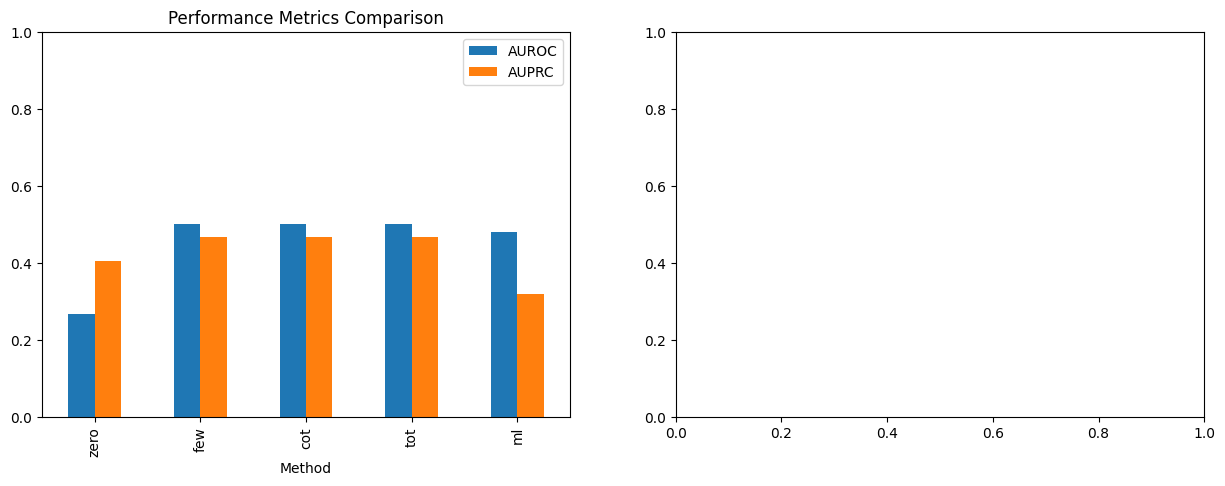

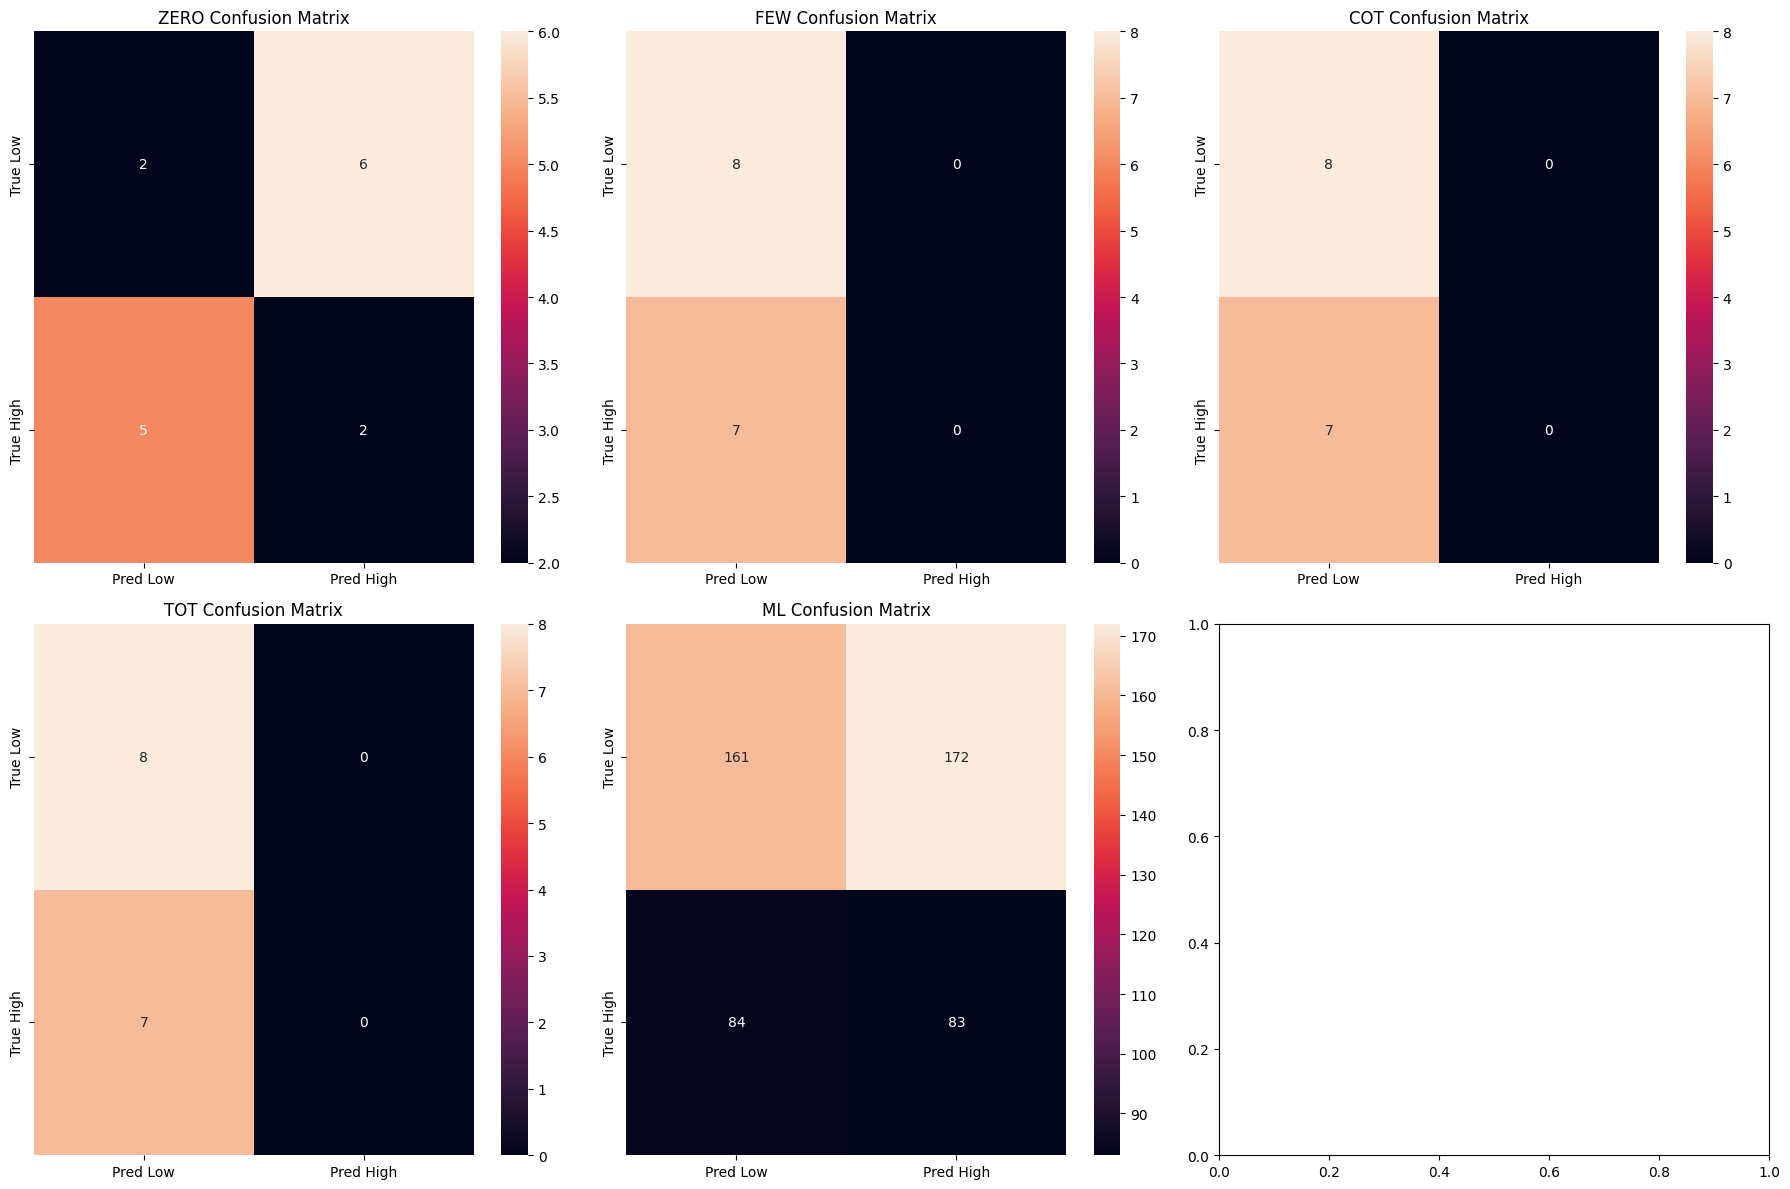

In [21]:
metrics_df = plot_comparison(llm_results)